# ECE 493 Assignment 3

Assignment Overview
- Learn pytorch and helper libraries
- Understand VOC Sementic Segmentation Dataset
- Create data transforms to augment the dataset
- Create the neural network
- Train and evaluate the neural network

Problems:
- 1) Data augmentation
- 2) Create the neural network

Note:
- This assignment was created based on assignment 4 of CS 484
 - https://cs.uwaterloo.ca/~yboykov/Courses/cs484/

# Importing libraries

Everything that you need for this assignment is imported here.

The VoxSegmentation dataset contains images and segmented images.
https://chainercv.readthedocs.io/en/stable/reference/datasets.html#chainercv.datasets.VOCSemanticSegmentationDataset


In [1]:
# You can run this cell to install packages
# I believe this is the only package not preinstalled on google colab
!pip install chainercv

In [2]:
# pytorch library
import torch
# neural network layers (Conv2d, Linear, etc.) that will be trained
# https://pytorch.org/docs/stable/nn.html
import torch.nn as nn
# Many functions (convolution, pooling, activation, etc.)
# https://pytorch.org/docs/stable/nn.functional.html
import torch.nn.functional as F
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader

# Contains pretrained models for transfer learning
# https://pytorch.org/docs/stable/torchvision/models.html
import torchvision.models as models
# import data transforms
# https://pytorch.org/docs/stable/torchvision/transforms.html
# Take note of transforms.ToPILImage and transforms.ToTensor
import torchvision.transforms as transforms


# Use cuda on the gpu or use the cpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# Overide device when testing on CPU
# device = 'cpu'

# graphing and images
import matplotlib.pyplot as plt
from PIL import Image

# numpy
import numpy as np

# deepcopy the nn
import copy

# for random number generation
import random

# chainerCV is similar to torchvision
import chainercv
# https://chainercv.readthedocs.io/en/stable/reference/datasets.html#chainercv.datasets.VOCSemanticSegmentationDataset
from chainercv.datasets import VOCSemanticSegmentationDataset
# https://docs.chainer.org/en/stable/reference/generated/chainer.datasets.TransformDataset.html#chainer.datasets.TransformDataset
from chainer.datasets import TransformDataset

# Used to calculate mIoU
from chainercv.evaluations import eval_semantic_segmentation


/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


# Import VOC Segmentation Dataset

In [3]:
import os.path
from os import path
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
DATASET_LOCATION = '/content/gdrive/MyDrive/'

if not path.exists(DATASET_LOCATION + 'VOC2012_3'):
  print('First time run, downloading VOC and copying to permanent location')
  # auto will download the dataset to $HOME/.chainer/dataset
  # This gets deleted when you disconnect from google colab
  voc_train_data = VOCSemanticSegmentationDataset(data_dir='auto', split='train')
  !cp -r $HOME/.chainer/dataset/pfnet/chainercv/voc/VOCdevkit/VOC2012/ /content/gdrive/MyDrive/

# Instantiate the data loader with the dataset directory
voc_train_data = VOCSemanticSegmentationDataset(data_dir=DATASET_LOCATION + 'VOC2012', split='train')

print("Number of training examples:", len(voc_train_data))
print("Each with one image and one ground truth (gt) segmented image:", len(voc_train_data[0]))

print("Image Shape:", voc_train_data[0][0].shape)
print("Segmented Image Shape:", voc_train_data[0][1].shape)

Mounted at /content/gdrive
First time run, downloading VOC and copying to permanent location
^C
Number of training examples: 1464
Each with one image and one ground truth (gt) segmented image: 2
Image Shape: (3, 281, 500)
Segmented Image Shape: (281, 500)


There are 22 Classes in VOC.

https://github.com/NVIDIA/DIGITS/blob/master/examples/semantic-segmentation/pascal-voc-classes.txt
- -1 is ignore
- 0 is background
- 1-20 are different objects

View count of pixels within each label category:
(array([-1,  0,  7, 15], dtype=int32), array([  4943, 142234,  15733,   3590]))
(array([-1,  0,  7, 15], dtype=int32), array([  3684, 150374,  32709,    733]))
(array([-1,  0,  2,  7, 15], dtype=int32), array([ 12802, 164053,   4518,    673,   5454]))
We must move the RGB channel to the back to be viewed with plt:
Before: (3, 333, 500)
After: (333, 500, 3)
Lastly let's verify that the image and gt label match


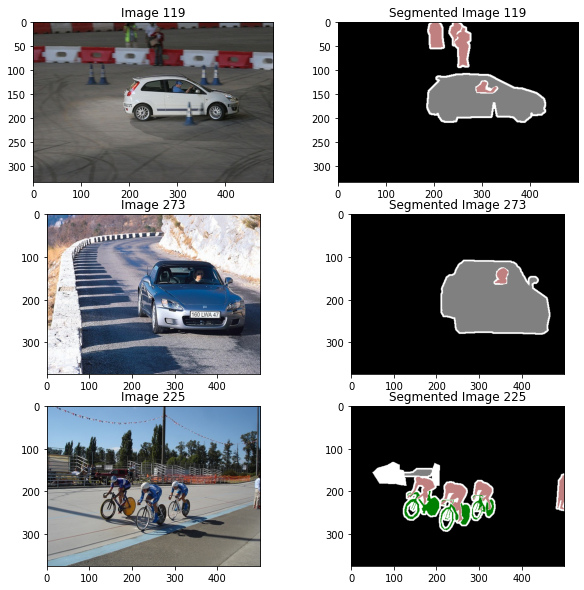

In [4]:
# Find images with people and cars
def find_car_and_ppl_images():
    car_label = 7
    person_label = 15
    count = 0
    max_count = 100
    for i in range(len(voc_train_data)):
        tmp_count = np.unique(voc_train_data[i][1], return_counts=True)
        if car_label in tmp_count[0] and person_label in tmp_count[0]:
            if count == max_count:
                break
            else:
                img, label = voc_train_data[i]
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)
                plt.title('Image ' + str(i))
                ax.imshow(np.rollaxis(img.astype(int), 0, 3))
                count += 1

# I used this function to find some relevant images
# find_car_and_ppl_images()

# Some relevant image indexes for a self-driving car
# Car = 119, 273, Bicycle = 225
img_119, seg_img_119 = voc_train_data[119]
img_273, seg_img_273 = voc_train_data[273]
img_225, seg_img_225 = voc_train_data[225]

print("View count of pixels within each label category:")
print(np.unique(voc_train_data[119][1], return_counts=True))
print(np.unique(voc_train_data[273][1], return_counts=True))
print(np.unique(voc_train_data[225][1], return_counts=True))

print("We must move the RGB channel to the back to be viewed with plt:")
print("Before:", img_119.shape)
print("After:", np.rollaxis(img_119, 0, 3).shape)

print("Lastly let's verify that the image and gt label match")

# This colorize_mask class takes in a numpy segmentation mask,
#  and then converts it to a PIL Image for visualization.
#  Since by default the numpy matrix contains integers from
#  0,1,...,num_classes, we need to apply some color to this
#  so we can visualize easier! Refer to:
#  https://pillow.readthedocs.io/en/4.1.x/reference/Image.html#PIL.Image.Image.putpalette
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

def add_img_plot(fig, index, img, title, sub_plot_id):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.imshow(img)

# Create the figure size
fig = plt.figure(figsize=(10,10))
# Car image 119
add_img_plot(fig, 119, np.rollaxis(img_119.astype(int), 0, 3), 'Image ', [3,2,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119), 'Segmented Image ', [3,2,2])
# Car image 273
add_img_plot(fig, 273, np.rollaxis(img_273.astype(int), 0, 3), 'Image ', [3,2,3])
add_img_plot(fig, 273, colorize_mask(seg_img_273), 'Segmented Image ', [3,2,4])
# Bicycle image 225
add_img_plot(fig, 225, np.rollaxis(img_225.astype(int), 0, 3), 'Image ', [3,2,5])
add_img_plot(fig, 225, colorize_mask(seg_img_225), 'Segmented Image ', [3,2,6])

# Problem 1 Data Augmentation

The transform below is used to create a transformed training dataset. It currently center crops all images.

Modify it so that:
- There is a 50% chance the images will be flipped horizontally
- Instead of a center crop, a random part of the image is cropped

Useful functions:
- chainercv.transforms.flip
- chainercv.transforms.random_crop

Note: The output image and segmented images should match

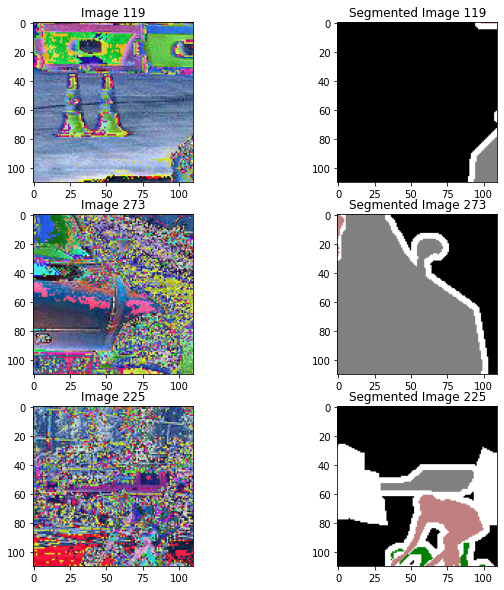

In [5]:
# From ImageNet
norm = ([0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])

# Modify this function
def voc_train_transform(in_data):
    size = (110,110)
    img, seg_img = in_data

    # Instead of a center crop, a random part of the image is cropped
    # Save slices to crop the segmented img
    img, param = chainercv.transforms.random_crop(img, size, return_param=True)

    # There is a 50% chance the images will be flipped horizontally
    flip_horizontally = random.randint(0,1)
    if (flip_horizontally == 1):
      img = chainercv.transforms.flip(img, x_flip=True)

    img = np.rollaxis(img, 0, 3)
    img = transforms.ToPILImage()(np.uint8(img))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(norm[0],norm[1])(img)

    # Add channel
    seg_img = seg_img[None]

    # output image and segmented img have same crop
    if (flip_horizontally == 1):
      seg_img = seg_img[:, param['y_slice'], param['x_slice']]
      seg_img = chainercv.transforms.flip(seg_img, x_flip=True)[0]
    else:
      seg_img = seg_img[:, param['y_slice'], param['x_slice']][0]

    return img, torch.from_numpy(seg_img).long()

img_119, seg_img_119 = voc_train_transform(voc_train_data[119])
img_273, seg_img_273 = voc_train_transform(voc_train_data[273])
img_225, seg_img_225 = voc_train_transform(voc_train_data[225])

# Create the figure size
fig = plt.figure(figsize=(10,10))
# Car image 119
add_img_plot(fig, 119, transforms.ToPILImage()(img_119), 'Image ', [3,2,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119.numpy()), 'Segmented Image ', [3,2,2])
# Car image 273
add_img_plot(fig, 273, transforms.ToPILImage()(img_273), 'Image ', [3,2,3])
add_img_plot(fig, 273, colorize_mask(seg_img_273.numpy()), 'Segmented Image ', [3,2,4])
# Bicycle image 225
add_img_plot(fig, 225, transforms.ToPILImage()(img_225), 'Image ', [3,2,5])
add_img_plot(fig, 225, colorize_mask(seg_img_225.numpy()), 'Segmented Image ', [3,2,6])

# Dataloader

In [6]:
voc_train_data_transformed = TransformDataset(voc_train_data, voc_train_transform)

# epoch = one iteration over the entire dataset
# batch size = samples per batch within an epoch
# shuffle = Set to True if your data is ordered
# num_workers = number of subprocess to use when dataloading, set higher if you have many cpu cores
if device == 'cpu':
    train_loader = DataLoader(voc_train_data_transformed, batch_size=5, shuffle=True, num_workers=10)
else:
    train_loader = DataLoader(voc_train_data_transformed, batch_size=50, shuffle=True, num_workers=2)

# Problem 2 Create the neural network

In [51]:
class Net(nn.Module):
    def __init__(self, num_classes, criterion=None):
        super(Net, self).__init__()
        self.criterion = criterion
        self.num_classes = num_classes
        
        self.conv2 = nn.Conv2d(576, 256, kernel_size=7, stride=2, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.conv3 = nn.Conv2d(256, 21, kernel_size=7, stride=2, bias=False)
        self.bn3 = nn.BatchNorm2d(21)

        # Hints:
        # Useful layers to train
        # - nn.Conv2d
        # - nn.BatchNorm2d
        # - nn.Dropout2d
        # You can import a pre-trained model
        self.resnet = models.resnet34(pretrained=True)

    def forward(self, inp, gts=None):

      output_size = (inp.size()[2], inp.size()[3])
      # print(output_size)
      
      # encoder
      # 5 (pre-trained) convolutional layers from "resnet"
      # print("FIRST")
      x = self.resnet.conv1(inp)
      # print(x.shape)
      x = self.resnet.bn1(x)
      # print(x.shape)
      x = self.resnet.relu(x)
      # print(x.shape)
      x = self.resnet.maxpool(x)
      # print(x.shape)
      
      # print("LAYER 1 (SKIP CONNECTION)")
      x = self.resnet.layer1(x)
      skip_conection = x
      # print(x.shape)
      
      # print("LAYER 2")
      x = self.resnet.layer2(x)
      # print(x.shape)
      
      # print("LAYER 3")
      x = self.resnet.layer3(x)
      # print(x.shape)
      
      # print("LAYER 4")
      x = self.resnet.layer4(x)
      # print(x.shape)

      # Hints: Useful functions
      # - F.relu        (neuron activation)
      # - F.interpolate (interpolate to increase tensor H and W)
      # - torch.cat     (concatonate tensors to implement a skip connection)

      # decoder

      # print("INTERPOLATE1")
      factor = (skip_conection.shape[2]/x.shape[2], skip_conection.shape[3]/x.shape[3])
      x = F.interpolate(x, scale_factor=factor)
      # print(x.shape)

      # print("CONCAT1")
      x = torch.cat((skip_conection, x), 1)
      # print(x.shape)

      # print("SECOND LAST")

      # print('CONV2')
      x = self.conv2(x)
      # print(x.shape)

      # print('BN2')
      x = self.bn2(x)
      # print(x.shape)

      # print('RELU')
      x = F.relu(x)
      # print(x.shape)

      # print('DROPOUT')
      x = self.dropout1(x)
      # print(x.shape)

      # print('CONV3')
      x = self.conv3(x)
      # print(x.shape)

      # print('BN3')
      x = self.bn3(x)
      # print(x.shape)

      # print('MAX-POOL')
      x = F.max_pool2d(x, 1)
      # print(x.shape) 

      # print('DROPOUT1')
      x = self.dropout1(x)
      # print(x.shape)

      # print('INTERPOLATE')
      x = F.interpolate(x, size=output_size)
      # print(x.shape) 

      # print('DROPOUT2')
      x = self.dropout2(x)
      # print(x.shape)

      # print('lfinal')
      lfinal = x
      # print(x.shape)

      if self.training:
          # Return the loss if in training mode
          return self.criterion(lfinal, gts)
      else:
          # Return the actual prediction otherwise
          return lfinal


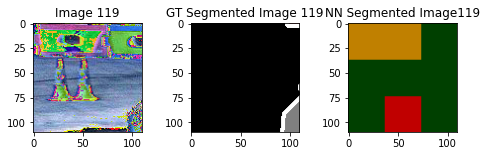

In [52]:
untrained_net = Net(21).to(device)
untrained_net.eval()

sample_img, sample_target = voc_train_data_transformed[119]

untrained_output = untrained_net.forward(sample_img[None].to(device))
if device != 'cpu':
    untrained_output = untrained_output.cpu()
untrained_nn_seg_img_119 = torch.argmax(untrained_output.cpu(), dim=1).numpy()[0]

# Create the figure size
fig = plt.figure(figsize=(8,2))
# Car image 119
add_img_plot(fig, 119, transforms.ToPILImage()(img_119), 'Image ', [1,3,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119.numpy()), 'GT Segmented Image ', [1,3,2])
add_img_plot(fig, 119, colorize_mask(untrained_nn_seg_img_119), 'NN Segmented Image', [1,3,3])

In [53]:
def train(train_loader, net, optimizer, loss_graph, device):

    for batch_idx, (data, target) in enumerate(train_loader):
        img, gt_seg_img = data.to(device), target.to(device)

        # This is a forward pass which also returns loss due to training mode
        main_loss = net(img, gts=gt_seg_img)

        # Populate this list to graph the loss
        loss_graph.append(main_loss.item())
        
        # View the loss within the epoch
        print(main_loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        main_loss.backward()
        optimizer.step()
        
    return main_loss

In [60]:
# You may switch the optimizer

# learning rate decreased from 0.1 to 0.01
# from research : "A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights but may take significantly longer to train"
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.01, # 0.001
                                weight_decay=1e-5,
                                momentum=0.5,
                                nesterov=False)
    return optimizer

Starting Training...
4.029627323150635
4.233867645263672
4.183069229125977
4.133426189422607
4.250813007354736
3.71684193611145
3.9881057739257812
3.83000111579895
3.7471933364868164
3.454237222671509
3.2164809703826904
3.5827443599700928
3.359532594680786
3.504488706588745
3.3650357723236084
3.421471357345581
3.471404552459717
3.1156084537506104
3.0611021518707275
3.437767267227173
3.36848783493042
3.383863687515259
3.2070207595825195
2.9005677700042725
3.20773983001709
2.9842898845672607
2.9775099754333496
2.898176670074463
3.2419681549072266
2.6915392875671387
Epoch: 0 Loss: 2.6915392875671387
3.037949562072754
3.1899266242980957
2.9994022846221924
3.005969524383545
3.248335361480713
2.929835557937622
2.8570444583892822
3.0855679512023926
2.795459032058716
2.8286163806915283
2.9757747650146484
2.8261842727661133
2.7240397930145264
2.4645204544067383
2.647068738937378
2.9230337142944336
2.9337644577026367
2.6864209175109863
2.7420098781585693
2.6690518856048584
2.871135950088501
2.78

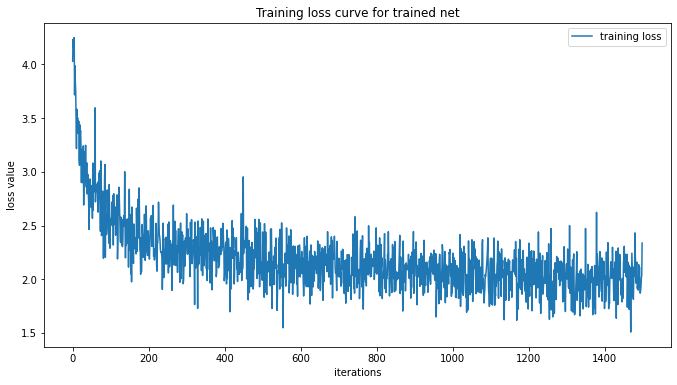

In [61]:
%%time
%matplotlib inline

# Deep copy in order to train the network with the same initialized weights
trained_net = copy.deepcopy(untrained_net)
trained_net = trained_net.to(device)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=-1)

# You can change the number of EPOCHS
EPOCH = 50

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph, device)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for trained net')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))


In [62]:
def validate(val_loader, net):
    iou_arr = []
    val_loss = 0

    net.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            img, gt_seg_img = data.to(device), target.to(device)

            output = net(img)

            # Convert to numpy arrays
            if device != 'cpu':
                output = output.cpu()
                gt_seg_img = gt_seg_img.cpu()
            pred = torch.argmax(output, dim=1).numpy()[0]

            gt_np = gt_seg_img.numpy()[0]

            conf = eval_semantic_segmentation(pred[None], gt_np[None])

            iou_arr.append(conf['miou'])
    
    return val_loss, (sum(iou_arr) / len(iou_arr))

# Validation

In [63]:
# a validation loader is created with a transform that doesn't modify the data
voc_val_data = VOCSemanticSegmentationDataset(data_dir=DATASET_LOCATION + 'VOC2012', split='val')

def val_transform(in_data):
    size = (110,110)
    img, seg_img = in_data

    img = np.rollaxis(img, 0, 3)
    img = transforms.ToPILImage()(np.uint8(img))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=norm[0],std=norm[1])(img)

    return img, torch.from_numpy(seg_img).long()

voc_val_data_transformed = TransformDataset(voc_val_data, val_transform)

# epoch = one iteration over the entire dataset
# batch size = samples per batch within an epoch
# shuffle = Set to True if your data is ordered
# num_workers = number of subprocess to use when dataloading, set higher if you have many cpu cores
val_loader = DataLoader(voc_val_data_transformed, batch_size=1, shuffle=True, num_workers=10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [64]:
%%time
print("mIoU over the training dataset:{}".format(validate(train_loader, trained_net)[1]))

/usr/local/lib/python3.7/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.7/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


mIoU over the training dataset:0.5868079122363342
CPU times: user 13.8 s, sys: 714 ms, total: 14.5 s
Wall time: 22.7 s


In [65]:
%%time
print("mIoU over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-pack

mIoU over the validation dataset:0.43306880597348596
CPU times: user 3min 41s, sys: 5.84 s, total: 3min 47s
Wall time: 3min 52s


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.7/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


View count of pixels within each label category:
(array([-1,  0,  7, 15]), array([  4943, 142234,  15733,   3590]))
(array([0, 7]), array([148824,  17676]))
View count of pixels within each label category:
(array([-1,  0,  7, 15]), array([  3684, 150374,  32709,    733]))
(array([0, 7]), array([158270,  29230]))
View count of pixels within each label category:
(array([-1,  0,  2,  7, 15]), array([ 12802, 164053,   4518,    673,   5454]))
(array([0]), array([187500]))


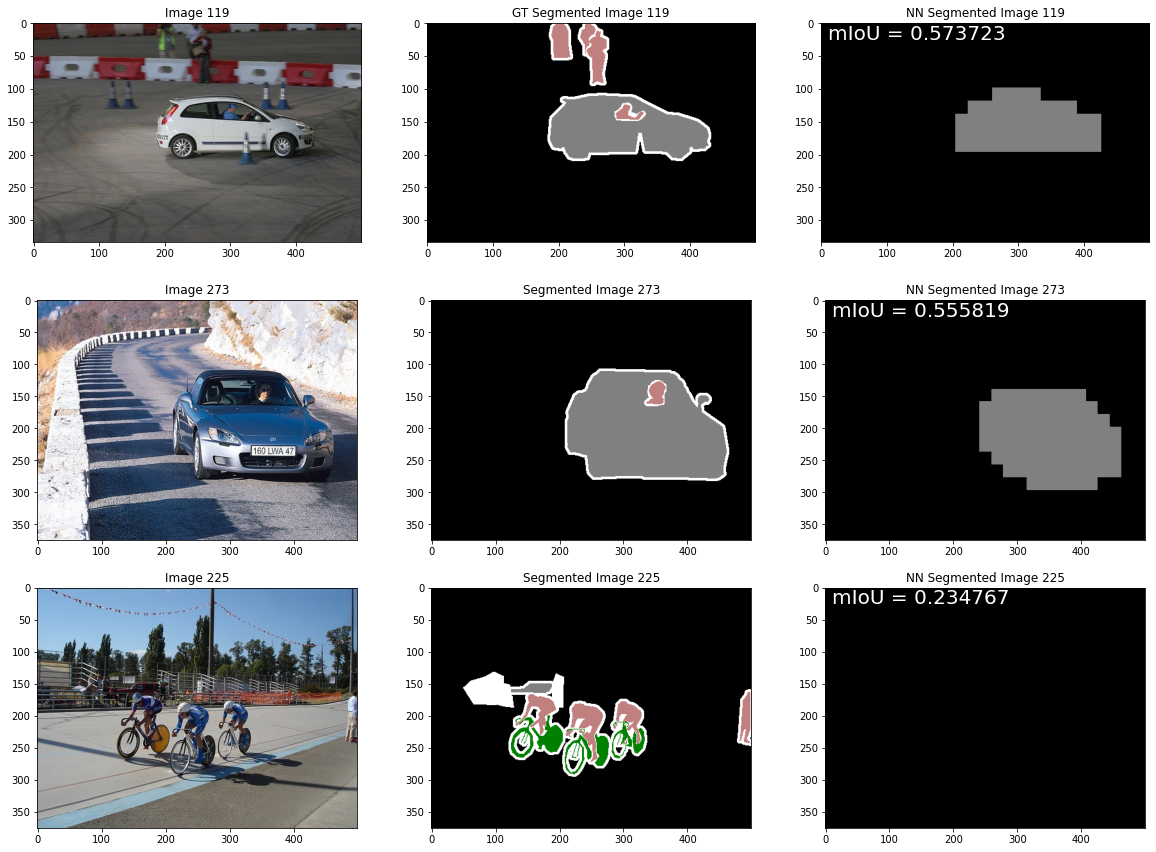

In [66]:
# switch back to evaluation mode
trained_net.eval()

def add_img_txt_plot(fig, index, img, title, sub_plot_id, txt):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.text(10, 25, 'mIoU = {:_>8.6f}'.format(txt), fontsize=20, color='white')
    ax.imshow(img)

def get_nn_seg_img(net, data):
    img, gt_seg_img = data

    nn_seg_output = net.forward(img[None].cuda())

    # computing mIOU (quantitative measure of accuracy for network predictions)
    if device != 'cpu':
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).cpu().numpy()[0]
    else:
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).numpy()[0]

    gts = gt_seg_img.cpu().numpy()

    conf = eval_semantic_segmentation(nn_seg_img[None], gts[None])

    print("View count of pixels within each label category:")
    print(np.unique(gt_seg_img, return_counts=True))
    print(np.unique(nn_seg_img, return_counts=True))

    return nn_seg_img, conf['miou']

# Some relevant image indexes for a self-driving car
# Car = 119, 273, Bicycle = 225
img_119, seg_img_119 = voc_train_data[119]
img_273, seg_img_273 = voc_train_data[273]
img_225, seg_img_225 = voc_train_data[225]

# Get NN Output
nn_seg_img_119, miou_119 = get_nn_seg_img(trained_net, val_transform(voc_train_data[119]))
nn_seg_img_273, miou_273 = get_nn_seg_img(trained_net, val_transform(voc_train_data[273]))
nn_seg_img_225, miou_225 = get_nn_seg_img(trained_net, val_transform(voc_train_data[225]))

# Create the figure size
fig = plt.figure(figsize=(20,15))
# Car image 119
add_img_plot(fig, 119, np.rollaxis(img_119.astype(int), 0, 3), 'Image ', [3,3,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119), 'GT Segmented Image ', [3,3,2])
add_img_txt_plot(fig, 119, colorize_mask(nn_seg_img_119), 'NN Segmented Image ', [3,3,3], miou_119)
# Car image 273
add_img_plot(fig, 273, np.rollaxis(img_273.astype(int), 0, 3), 'Image ', [3,3,4])
add_img_plot(fig, 273, colorize_mask(seg_img_273), 'Segmented Image ', [3,3,5])
add_img_txt_plot(fig, 273, colorize_mask(nn_seg_img_273), 'NN Segmented Image ', [3,3,6], miou_273)
# Bicycle image 225
add_img_plot(fig, 225, np.rollaxis(img_225.astype(int), 0, 3), 'Image ', [3,3,7])
add_img_plot(fig, 225, colorize_mask(seg_img_225), 'Segmented Image ', [3,3,8])
add_img_txt_plot(fig, 225, colorize_mask(nn_seg_img_225), 'NN Segmented Image ', [3,3,9], miou_225)
